In [1]:
!pip install gdown
!gdown --id '1DK1WqbL8cUay22U5ZsSiHP-XhH8QIIp6'
!gdown --id '1-32iu5JwfVSaKbmH5wf8ERkTr6klfBO5'
!gdown --id '1059GXsExnp6VAqRl4c5kuyK2-NCK7dUD'

  Using cached gdown-4.2.0-py3-none-any.whl
Downloading...
From: https://drive.google.com/uc?id=1DK1WqbL8cUay22U5ZsSiHP-XhH8QIIp6
To: /home/jovyan/git-repos/waveforms_signal.nc
100%|██████████████████████████████████████| 12.9G/12.9G [02:26<00:00, 87.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-32iu5JwfVSaKbmH5wf8ERkTr6klfBO5
To: /home/jovyan/git-repos/waveforms_names_signal.csv
100%|███████████████████████████████████████| 60.5M/60.5M [00:00<00:00, 201MB/s]
Downloading...
From: https://drive.google.com/uc?id=1059GXsExnp6VAqRl4c5kuyK2-NCK7dUD
To: /home/jovyan/git-repos/Attributes.csv
100%|█████████████████████████████████████████| 371M/371M [00:01<00:00, 234MB/s]


In [2]:
!pip install numpy pandas --upgrade -q
!pip install --upgrade git+https://github.com/IMGW-univie/seismic-augmentation.git
!pip install julius
# !pip install wandb -q
# !pip install augly[av]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
  Cloning https://github.com/IMGW-univie/seismic-augmentation.git to /tmp/pip-req-build-g7hewadi
  Running command git clone -q https://github.com/IMGW-univie/seismic-augmentation.git /tmp/pip-req-build-g7hewadi
  Created wheel for seismic-augmentation: filename=seismic_augmentation-0.1-py3-none-any.whl size=4516 sha256=f47be07d939a74dcb7467f4dc0b458e78da98666345102fbf408ef5ed137d3db
  Stored in directory: /tmp/pip-ephem-wheel-cache-9627fq79/wheels/fe/fe/79/164d16e51cb9a57d0457db04857f8d171e1c1a8cb12912dc00
Successfully built seismic-augmentation
  Using cached julius-0.2.6-py3-none-any.whl


In [3]:
!pip install seaborn

     |████████████████████████████████| 292 kB 5.5 MB/s eta 0:00:01


In [4]:
import copy
import io
import math
import multiprocessing as mp
import os
import random
from argparse import ArgumentParser
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import obspy
import pandas as pd
import pytorch_lightning as pl
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import seed_everything
from torch.utils.data import DataLoader, Dataset, IterableDataset, random_split
from tqdm.notebook import tqdm

seed_everything(42)

import xarray

import wandb

Global seed set to 42


In [84]:
import warnings

warnings.filterwarnings("ignore")

# define function to calculate equal-frequency bins
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1), np.arange(nlen), np.sort(x))


def bin_data(signal_attributes, attribute, label, n_bins, axis_title):
    signal_attributes[label] = 0

    # create histogram with equal-frequency bins
#     n, bins, patches = plt.hist(
#         signal_attributes[attribute],
#         equalObs(signal_attributes[attribute], n_bins),
#         edgecolor="black",
#     )
    n, bins, patches = plt.hist(
        signal_attributes[attribute],
        equalObs(signal_attributes[attribute], n_bins),
        edgecolor="black", color="lightblue"
    )
    plt.title(axis_title, fontsize=15)
    plt.savefig(f'{attribute}_bins.pdf') 
    # Assign labels
    for i in range(len(bins) - 1):
        signal_attributes[label][
            (signal_attributes[attribute] >= bins[i])
            & (signal_attributes[attribute] <= bins[i + 1])
        ] = i
    #print(bins)
    #print(len(bins))
    return signal_attributes, bins

In [6]:
def parse_snr_z(val):
    val = val.replace('[', '').split(' ')
    val = [x for x in val if x!=''][0]
    return float(val)
    

In [7]:
# Format - ZNE
da_data = xarray.open_dataset("./waveforms_signal.nc", engine="netcdf4").load()

In [86]:
signal_labels = pd.read_csv("./waveforms_names_signal.csv")
attributes = pd.read_csv("./Attributes.csv")
attributes = attributes.loc[attributes.snr_db.isin(attributes.snr_db.dropna().unique())]
attributes['snr_db_z'] = attributes['snr_db'].apply(lambda x: parse_snr_z(x))

signal_labels = pd.DataFrame({"trace_name": signal_labels["Z"].str[:-6].values})
signal_attributes = pd.merge(signal_labels, attributes, on="trace_name")

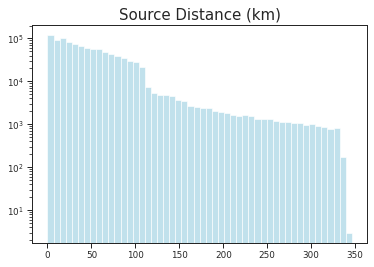

In [9]:
import seaborn as sns
#attributes.s_arrival_sample.hist()
#sns.set_style("white")
sns.set_style("ticks")
 
# Smallest context:
sns.set_context("paper")
#attributes.source_distance_km.hist()
ax = sns.histplot(data=attributes, x="source_distance_km",  bins=50, color="lightblue")
#ax = sns.displot(data=attributes, x='source_distance_km', kind='hist', height=4, aspect=1.4, bins=50, color="lightblue")
ax.set_yscale('log')
ax.set(xlabel=None, ylabel=None)
ax.set_title("Source Distance (km)", fontsize=15)
plt.savefig('source_distance_km_dist_log.pdf') 

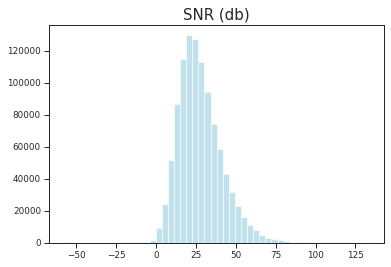

In [10]:

#sns.set_style("whitegrid")
#ax = sns.displot(data=attributes, x='snr_db_z', kind='hist', height=4, aspect=1.4, bins=50, color="lightblue")
ax = sns.histplot(data=attributes, x="snr_db_z",  bins=50, color="lightblue")
#ax.set_yscale('log')
ax.set(xlabel=None, ylabel=None) #, font=12)
ax.set_title("SNR (db)", fontsize=15)
plt.savefig('snr_db.pdf') 

In [9]:
#attributes.snr_db.unique()
#966072
#attributes.shape
#1265657
#attributes.loc[attributes.snr_db.isin(attributes.snr_db.dropna().unique())].shape
#1030231

In [11]:
def transform(sample):
    return sample/np.abs(sample).max()

In [12]:
# import torch
from seismic_augmentation.composition import Compose
from seismic_augmentation.augmentations import *

def transform(sample):
    aug = Compose([
         #FlipChannels(init_channel_order='ZNE'),
         #AddRandomNoise(snr_level_db = -10),
         # RandomLowPassFilter(cutoff_freq_range=[1,10]), 
         # RandomHighPassFilter(cutoff_freq_range=[3,14]),
         Taper(max_percentage = 0.5, max_length=10),
         PolarityChange(),
         Normalize()
         ],  
         p=0.4)
    #print(f"waveform size {sample.size()}")
    transformed = aug(data=sample, sample_rate=1)
    #print(f"transformed size {transformed.size()}")
    return transformed

In [13]:
class EQsDataset_labels(Dataset):
    def __init__(self, dataset, labels_1=None, labels_2=None, transform=False):
        self.dataset = dataset
        self.labels_1 = labels_1
        self.labels_2 = labels_2
        self.transform = transform

    def __getitem__(self, idx):
        # Loading
        signal = da_data.sel(index=idx).to_array().values[0]
        signal = torch.FloatTensor(signal)


        if self.transform:
            # signal = self.transform(torch.from_numpy(signal).unsqueeze(0), sample_rate=30).squeeze()
            signal = self.transform(signal)
        # signal = torch.FloatTensor(signal)

        if type(self.labels_2) == type(None):
            label = torch.tensor(self.labels_1[idx])
        else:
            label = torch.tensor([self.labels_1[idx], self.labels_2[idx]])
        return signal, label

    def __len__(self):
        return self.dataset.dims["index"]

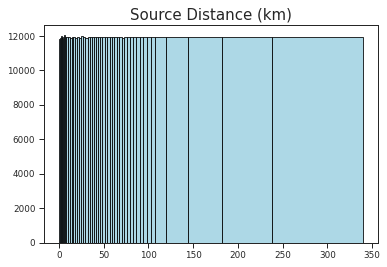

In [82]:
#attribute = "back_azimuth_deg"
# signal_attributes[attribute][signal_attributes[attribute] > 180] -= 180 
attribute = 'source_distance_km'
n_bins = 50
signal_attributes, bins = bin_data(signal_attributes, attribute, "label_1", n_bins, axis_title="Source Distance (km)")

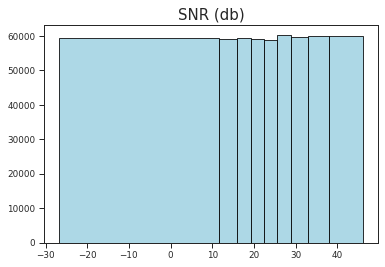

In [16]:
# signal to noise ratio
attribute = 'snr_db_z'
n_bins = 10
signal_attributes, _ = bin_data(signal_attributes, attribute, 'label_1', n_bins, axis_title="SNR (db)")

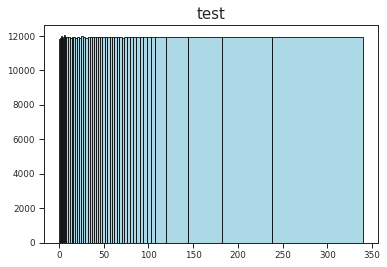

In [78]:
# S arrival
attribute = 'source_distance_km'
n_bins = 50
signal_attributes = bin_data(signal_attributes, attribute, 'label_1', n_bins, axis_title='test')

In [19]:
signal_dataset = EQsDataset_labels(
    da_data, labels_1=signal_attributes["label_1"], labels_2=None, transform=transform
)
n_classes = len(signal_attributes["label_1"].unique())

In [20]:
def plot_samples_from_the_dataset(full_dataset, dim=4, channels=3):

    channel_names = {0: "Z", 1: "N", 2: "E"}
    if channels == 1:
        fig, ax = plt.subplots(
            ncols=dim, nrows=dim, sharex=True, sharey=True, figsize=(20, 7.5)
        )
        for column in range(dim):
            for row in range(dim):
                indx = np.random.randint(0, len(full_dataset))
                sample = full_dataset[indx]
                color = np.array(np.random.choice(range(256), size=3)) / 255
                ax[column, row].plot(full_dataset[indx, 0], color=color, linewidth=0.5)
                ax[column, row].set_title(
                    "Index: %i. Attribute: %.2f" % (index, sample[1])
                )

    if channels == 3:
        fig, ax = plt.subplots(
            ncols=dim, nrows=channels, sharex=True, sharey=True, figsize=(20, 7.5)
        )
        for column in range(dim):
            row = 0
            color = np.array(np.random.choice(range(256), size=3)) / 255
            indx = np.random.randint(0, len(full_dataset))
            sample = full_dataset[indx][1]
            for channel in range(channels):
                ax[row, column].plot(
                    full_dataset[indx][0][channel], color=color, linewidth=0.5
                )
                if len(sample.size()) == 0:
                    ax[row, column].set_title(
                        "Idx: %i. Channel: %s. Label: %.1f"
                        % (indx, channel_names[channel], sample)
                    )
                else:
                    ax[row, column].set_title(
                        "Idx: %i. Channel: %s. Label1: %.1f, Label2: %.1f"
                        % (indx, channel_names[channel], sample[0], sample[1])
                    )  # change for something smarter
                row += 1

    fig.suptitle("Individual samples")


# plot_samples_from_the_dataset(train_dataset, dim=3)

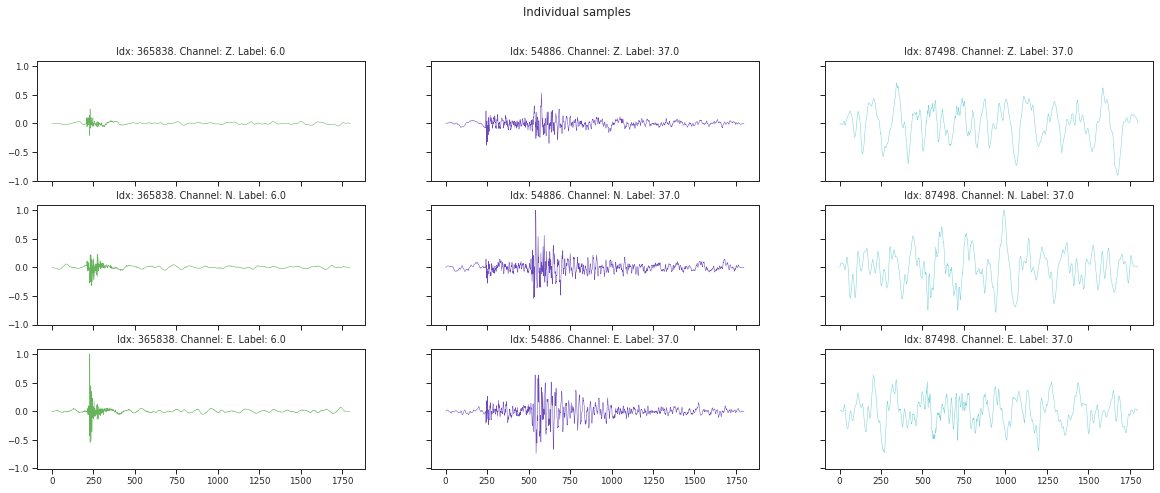

In [21]:
# plot_samples_from_the_dataset(signal_dataset_sd_km, dim=3, channels=3)
plot_samples_from_the_dataset(signal_dataset, dim=3, channels=3)

In [22]:
class EQDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size: int = 512, num_workers: int = 4, **kwargs):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dims = (3, 1800)  # 3 to 1
        self.dataset = dataset
        self.kwargs = kwargs

    def train_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            **self.kwargs
        )

In [24]:
## Model

In [23]:
import os
from argparse import ArgumentParser, Namespace
from collections import OrderedDict

import numpy as np
import obspy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.core import LightningModule
from pytorch_lightning.trainer import Trainer
from scipy.stats import truncnorm
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# def truncated_z_sample(batch_size, z_dim, truncation=0.5, seed=None):
#     values = truncnorm.rvs(-2, 2, size=(batch_size, z_dim))
#     return truncation * values


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class CustomSwish(nn.Module):
    def forward(self, input_tensor):
        return Swish.apply(input_tensor)

In [24]:
class ResBlock(nn.Module):
    def __init__(self, in_feat=1, out_feat=1024, kernel=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_feat,
            out_feat,
            kernel_size=kernel,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.conv2 = nn.Conv1d(
            out_feat,
            out_feat,
            kernel_size=kernel,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.batch_norm1 = nn.InstanceNorm1d(out_feat)
        self.batch_norm2 = nn.InstanceNorm1d(out_feat)
        self.swish = CustomSwish()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.batch_norm1(x).type_as(x)

        x = self.swish(x)
        x = self.conv2(x)
        x = self.batch_norm2(x).type_as(x)
        return self.swish(x + residual)

In [25]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape, n_classes, n_labels):
        super().__init__()
        self.register_buffer(
            name="label_emb", tensor=torch.randn(img_shape[0], latent_dim)
        )

        self.img_shape = img_shape
        self.n_labels = n_labels

        label_emb = []
        for i in range(self.n_labels):
            label_emb.append(nn.Embedding(n_classes, latent_dim))
        self.label_emb = nn.ModuleList(label_emb)

        self.project_embed = nn.Linear(latent_dim, latent_dim)

        self.res_block_1 = ResBlock(
            in_feat=1, out_feat=128, kernel=9, stride=1, padding=4
        )
        self.res_block_2 = ResBlock(
            in_feat=128, out_feat=128, kernel=9, stride=1, padding=4
        )
        self.res_block_3 = ResBlock(
            in_feat=128, out_feat=128, kernel=9, stride=1, padding=4
        )
        #         self.res_block_4 = ResBlock(in_feat=128, out_feat=128, kernel=3, stride=1, padding=1)

        self.upsample = nn.Upsample(scale_factor=2)

        self.final = nn.Sequential(
            nn.Conv1d(128, img_shape[0], 3, stride=1, padding=1),
            nn.Linear(latent_dim * 8, 1800),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        embed = torch.ones_like(z).type_as(z)

        if len(labels.size()) == 1:
            labels = labels.unsqueeze(-1)

        for i in range(labels.size(1)):
            embed *= self.label_emb[i](labels[:, i]).view(z.size(0), -1)

        z = torch.mul(embed, z).unsqueeze(1)
        # z = torch.cat([z, self.label_emb(labels)], dim=-1).unsqueeze(1)
        z = self.project_embed(z)

        img = self.res_block_1(z)
        img = self.upsample(img)

        img = self.res_block_2(img)
        img = self.upsample(img)

        img = self.res_block_3(img)
        img = self.upsample(img)

        #         img = self.res_block_4(img)
        #         img = self.upsample(img)

        img = self.final(img).squeeze()
        return img

In [26]:
class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes, n_labels):
        super(Discriminator, self).__init__()

        self.channels = img_shape[0]
        self.length = img_shape[-1]
        self.n_labels = n_labels

        def discriminator_block(in_feat, out_feat, ks=15, stride=2, pad=7, bn=True):
            block = [
                spectral_norm(nn.Conv1d(in_feat, out_feat, 15, 2, 7)),
                #                                 nn.LeakyReLU(0.2, inplace=True),
                CustomSwish(),
                nn.Dropout(0.5),
            ]
            if bn:
                block.append(nn.BatchNorm1d(out_feat, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_shape[0], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
        )

        self.adv_layer = spectral_norm(nn.Linear(512 * 29, 1))  # Real or Fake?
        self.aux_layer = spectral_norm(
            nn.Linear(512 * 29, self.n_labels * n_classes)
        )  # What class does it belong to?

    def forward(self, img):

        # print('IMG', img.size())
        # print(img.view(-1, self.channels, self.length).size())
        out = self.model(img.view(-1, self.channels, self.length))
        # print('OUT1', out.size())
        out = out.view(out.shape[0], -1)

        #        print('OUT2', out.size())
        validity = self.adv_layer(out)
        labels = self.aux_layer(out).view(out.shape[0], self.n_labels, -1)
        return validity, labels

In [27]:
class ACGAN(LightningModule):
    def __init__(
        self,
        latent_dim: int = 200,
        n_classes: int = None,
        n_labels: int = None,
        lr: float = 0.00001,  # 0.0001, #0.00005 works
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = 128,
        channels: int = 3,
        **kwargs
    ):

        super().__init__()
        self.save_hyperparameters()

        self.latent_dim = latent_dim

        self.n_classes = n_classes
        self.n_labels = n_labels

        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size

        self.channels = channels

        # networks
        img_shape = (channels, 1800)
        self.img_shape = img_shape

        def weights_init(m):
            classname = m.__class__.__name__
            if classname.find("Conv") != -1:
                nn.init.orthogonal_(m.weight.data, 1.0)
            # elif classname.find('BatchNorm') != -1:
            #     m.weight.data.normal_(1.0, 0.02)
            #     m.bias.data.fill_(0)
            elif classname.find("Linear") != -1:
                nn.init.orthogonal_(m.weight.data, 1.0)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

        self.generator = Generator(
            latent_dim=self.latent_dim,
            img_shape=self.img_shape,
            n_classes=self.n_classes,
            n_labels=self.n_labels,
        )
        self.discriminator = Discriminator(
            img_shape=img_shape, n_classes=n_classes, n_labels=self.n_labels
        )

        # Initialize weights in a similar fashion
        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

        self.validation_z = torch.cat(
            [torch.randn(1, self.latent_dim)] * 5
        )  # Same noise 5 times

        #         self.validation_z = torch.cat([torch.tensor(np.random.rayleigh(scale=1, size=(1, self.latent_dim)))]*5) #Same noise 5 times (trick from BigGAN)

        self.validation_labels = torch.tensor(
            [
                0,
                1 * (n_classes / 5),
                2 * (n_classes / 5),
                3 * (n_classes / 5),
                n_classes - 1,
            ]
        )

        self.example_input_array = (
            torch.zeros(2, self.latent_dim),
            torch.LongTensor(np.random.randint(0, self.n_classes, 2)),
        )

    #         self.accuracy = pl.metrics.Accuracy()

    def forward(self, z, labels):
        return self.generator(z, labels.long())

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def auxiliary_loss(self, y_hat, y):
        if self.n_labels == 1:
            return F.cross_entropy(y_hat.squeeze(), y.squeeze())
        else:
            loss = 0
            for i in range(self.n_labels):
                loss += F.cross_entropy(y_hat[:, i, :], y[:, i])
            return loss / self.n_labels

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, labels = batch
        labels = labels.long()

        # sample noise
        z = torch.randn(imgs.shape[0], self.latent_dim)
        z = z.type_as(imgs)

        gen_labels = torch.LongTensor(
            np.random.randint(0, self.n_classes, size=(z.size(0), self.n_labels))
        )
        gen_labels = gen_labels.type_as(labels)

        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        #         print('Gen_labels', gen_labels.min(), gen_labels.max())

        # train discriminator
        if optimizer_idx == 0:
            # Measure discriminator's ability to classify real from generated samples
            # how well can it label as REAL?
            validity, pred_label = self.discriminator(imgs)
            real_loss = self.adversarial_loss(validity, valid) + self.auxiliary_loss(
                pred_label, labels
            )

            # how well can it label as FAKE?
            gen_imgs = self(z, gen_labels)
            fake_validity, fake_pred_label = self.discriminator(gen_imgs)

            fake_loss = self.adversarial_loss(
                fake_validity, fake
            ) + self.auxiliary_loss(fake_pred_label, gen_labels)
            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2

            self.log("d_loss", d_loss, on_step=True, prog_bar=True)
            return d_loss

        # train generator
        if optimizer_idx == 1:
            # generate images
            self.generated_imgs = self(z, gen_labels)

            # adversarial loss is binary cross-entropy
            validity, pred_label = self.discriminator(self(z, gen_labels))
            g_loss = self.adversarial_loss(validity, valid) + self.auxiliary_loss(
                pred_label, gen_labels
            )

            self.log("g_loss", g_loss, on_step=True, prog_bar=True)
            return g_loss

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(
            self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2)
        )
        opt_d = torch.optim.Adam(
            self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2)
        )
        # dis_sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt_d, T_max=10) # https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html
        return [opt_d, opt_g], []

    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.final[0].weight)
        labels = self.validation_labels.type_as(self.generator.final[0].weight).long()
        #         # print('labels = {}'.format(labels))
        #         #  log sampled images

        sample_arrays = self(z, labels).view(-1, self.img_shape[0], self.img_shape[-1])
        fig = gen_plot(sample_arrays, labels)
        self.logger.experiment.log({"generated_images": fig})
        plt.close()
#         ckpt_path = f"{self.save_path}_e{epoch}.ckpt"
#         self.trainer.save_checkpoint(ckpt_path)


#         self.logger.experiment.add_image('generated_images', gen_plot(sample_arrays, labels), self.current_epoch,
#                                          dataformats='HWC')
#         self.logger.experiment.add_image('decoder_images', gen_plot(decoder), self.current_epoch, dataformats='HWC')

#         # add histograms
#         for name, params in self.named_parameters():
#             self.logger.experiment.add_histogram(name, params, self.current_epoch)

#         self.logger.experiment.flush()

In [28]:
# Конвертируем наши waveforms в PIL картинку (что бы логать в борде)
def gen_plot(sample_arrays, labels):
    if sample_arrays.size(1) == 1:
        fig, ax = plt.subplots(
            nrows=sample_arrays.size(0) * sample_arrays.size(1),
            ncols=2,
            figsize=(10, 10),
        )
    else:
        fig, ax = plt.subplots(
            nrows=sample_arrays.size(0) * sample_arrays.size(1),
            ncols=2,
            figsize=(10, 20),
        )

    colors = [
        "#03071e",
        "#ef476f",
        "#f48c06",
        "#9d0208",
        "#06D6A0",
        "#dc2f02",
        "#118AB2",
        "#f48c06",
        "#073B4C",
        "#ffba08",
    ]
    NFFT = 2 ** 6

    row = 0
    for num, i in enumerate(sample_arrays):
        for channel in range(sample_arrays.size(1)):
            ax[row, 0].plot(
                np.arange(0, 60, 60 / len(i[channel].detach().cpu())),
                i[channel].detach().cpu(),
                color=colors[num],
                linewidth=0.5,
            )
            ax[row, 0].set_ylim(-1, 1)
            ax[row, 1].specgram(
                i[0].detach().cpu(),
                NFFT=NFFT,
                Fs=30,
                noverlap=NFFT * 0.9,
                scale="dB",
                cmap="inferno",
            )
            ax[row, 0].set_ylabel("Class %i" % labels[num])
            row += 1

    #     buf = io.BytesIO()
    #     plt.savefig(buf, format='png');
    #     buf.seek(0);
    #     plt.close(fig)
    #     image = tf.image.decode_png(buf.getvalue(), channels=4);
    #     return torch.tensor(image.numpy())
    return fig

In [31]:
wandb.init()

wandb: Currently logged in as: krisztina-sinkovics (use `wandb login --relogin` to force relogin)


In [32]:
import obspy
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

# logger = TensorBoardLogger("lightning_logs", name='cGAN')
logger = WandbLogger(project="TEDE GAN", log_model="all", name="snr_50", entity='univei')

dm = EQDataModule(dataset=signal_dataset, shuffle=True)

model = ACGAN(n_classes=n_classes, n_labels=1)

trainer = Trainer(
    gpus=-1,
    progress_bar_refresh_rate=100,
    logger=logger,
    #                   accelerator='dp',
    precision=16,
    #                   fast_dev_run=True,
    #     limit_train_batches=0.01,
    #                   track_grad_norm=2,
    max_epochs=150,
    benchmark=True,
)

trainer.fit(model, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | In sizes        | Out sizes   
---------------------------------------------------------------------------------
0 | generator     | Generator     | 3.7 M  | [[2, 200], [2]] | [2, 3, 1800]
1 | discriminator | Discriminator | 3.4 M  | ?               | ?           
---------------------------------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
14.103    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
# Ideas for seismic transofrmations:
# Frequency filtering (LowPass, HighPass)
# Azimuth augmentation (switch N and E channels + flip the label)
# More fancy rotations
# Amplitude normalization
# Amplitude scaling (varying with time)
# Time warping

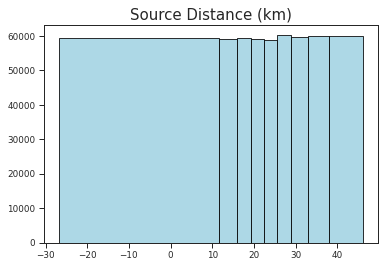

In [108]:
#attribute = "back_azimuth_deg"
# signal_attributes[attribute][signal_attributes[attribute] > 180] -= 180 
attribute = 'snr_db_z'
n_bins = 10
signal_attributes, bins = bin_data(signal_attributes, attribute, "label_1", n_bins, axis_title="Source Distance (km)")

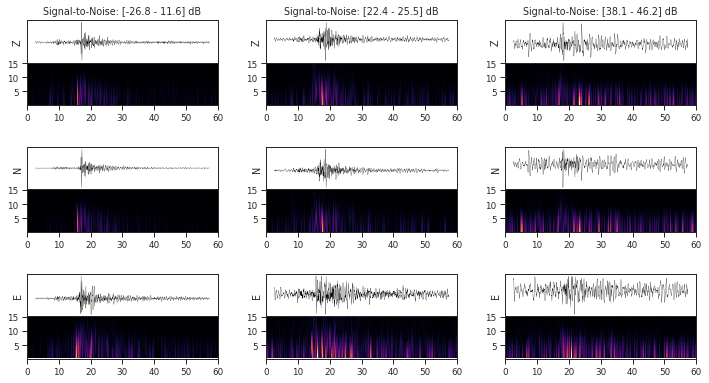

In [113]:
import matplotlib.gridspec as gridspec


nbins = 10
n_classes=20
nrows = 3

model = ACGAN(n_classes=n_classes, n_labels=1)
model = model.load_from_checkpoint('epoch=199-step=232999.ckpt').to('cpu')
model.eval()

fig = plt.figure(constrained_layout=True, figsize=(12, 7))
spec = gridspec.GridSpec(ncols=nrows, nrows=9, figure=fig)

ax_waveform_1_Z = fig.add_subplot(spec[0, 0])
ax_waveform_1_N = fig.add_subplot(spec[3, 0])
ax_waveform_1_E = fig.add_subplot(spec[6, 0])

ax_spec_1_Z = fig.add_subplot(spec[1:2, 0])
ax_spec_1_N = fig.add_subplot(spec[4:5, 0])
ax_spec_1_E = fig.add_subplot(spec[7:8, 0])

ax_waveform_2_Z = fig.add_subplot(spec[0, 1])
ax_waveform_2_N = fig.add_subplot(spec[3, 1])
ax_waveform_2_E = fig.add_subplot(spec[6, 1])

ax_spec_2_Z = fig.add_subplot(spec[1:2, 1])
ax_spec_2_N = fig.add_subplot(spec[4:5, 1])
ax_spec_2_E = fig.add_subplot(spec[7:8, 1])

ax_waveform_3_Z = fig.add_subplot(spec[0, 2])
ax_waveform_3_N = fig.add_subplot(spec[3, 2])
ax_waveform_3_E = fig.add_subplot(spec[6, 2])

ax_spec_3_Z = fig.add_subplot(spec[1:2, 2])
ax_spec_3_N = fig.add_subplot(spec[4:5, 2])
ax_spec_3_E = fig.add_subplot(spec[7:8, 2])

noise = torch.randn(1,200)

for num, (i, ax_spec_list, ax_wave_list) in enumerate(zip(np.linspace(0, nbins-2, nrows).astype(int),
                                                       [[ax_waveform_1_Z, ax_waveform_1_N, ax_waveform_1_E], 
                                                        [ax_waveform_2_Z, ax_waveform_2_N, ax_waveform_2_E],
                                                        [ax_waveform_3_Z, ax_waveform_3_N, ax_waveform_3_E]], 
                                                       [[ax_spec_1_Z, ax_spec_1_N, ax_spec_1_E],
                                                        [ax_spec_2_Z, ax_spec_2_N, ax_spec_2_E],
                                                        [ax_spec_3_Z, ax_spec_3_N, ax_spec_3_E]])):
    with torch.no_grad():
        pred = model(noise, torch.tensor([i]).unsqueeze(0))#.to('cuda')
        
        st = obspy.Stream()
        for k, ch in zip(range(3), ['Z','N','E']):
            tr = obspy.Trace(pred[k].numpy())
            tr.stats.sampling_rate = 30
            tr.stats.channel = ch
            st+=tr
        st.filter('highpass', freq=1)
        
        for ch, ax_wave, ax_spec, ch_name in zip(range(3),
                                                 ax_spec_list,
                                                 ax_wave_list,
                                                 ['Z','N','E']):
            ax_wave.plot(st[ch], linewidth=0.25, color='black')
            st[ch].spectrogram(cmap='inferno', axes=ax_spec)
#             ax_wave.set_ylim(-1,1)
            ax_wave.set_xticks([])
            ax_wave.set_yticks([])
            ax_wave.set_ylabel(ch_name)
            if ch == 0:
                ax_wave.set_title('Signal-to-Noise: [%.1f - %.1f] dB' % (bins[i], bins[i+1]))

plt.subplots_adjust(hspace=0, wspace=0.25)
plt.savefig('SNR_poster.pdf')